In [10]:
%pip install micromlgen

ERROR: Could not find a version that satisfies the requirement micromlgen (from versions: none)
ERROR: No matching distribution found for micromlgen
Note: you may need to restart the kernel to use updated packages.


In [18]:
import pandas as pd
import numpy as np
import itertools

#from micromlgen import port

from skimage.color import rgb2lab

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, classification_report

import xgboost as xgb


import data

In [19]:
colors_df = pd.read_csv("./data_labeled_ambient.csv", usecols=["red", "green", "blue", "ambient", "label"])

add combined features

In [36]:
colors_df['red_denoise'] = (colors_df['red'] - colors_df['ambient']).clip(lower=0)
colors_df['green_denoise'] = (colors_df['green'] - colors_df['ambient']).clip(lower=0)
colors_df['blue_denoise'] = (colors_df['blue'] - colors_df['ambient']).clip(lower=0)

In [24]:
noise = colors_df[['red', 'green', 'blue']].min(axis=1)
colors_df['diff_min_red'] = colors_df['red'] - noise
colors_df['diff_min_green'] = colors_df['green'] - noise
colors_df['diff_min_blue'] = colors_df['blue'] - noise

maxval = colors_df[['red', 'green', 'blue']].max(axis=1)
colors_df['diff_max_red'] = maxval - colors_df['red']
colors_df['diff_max_green'] = maxval - colors_df['green']
colors_df['diff_max_blue'] = maxval - colors_df['blue']

In [34]:
colors_df['red_denoise']

0       33.2
1       31.0
2       30.8
3       29.0
4       26.7
        ... 
1012    25.2
1013    27.2
1014    25.7
1015    26.2
1016    28.3
Name: red_denoise, Length: 1017, dtype: float64

In [114]:
## skip this block. this are all the features i could come up with.
epsilon = 1e-6
colors_df['intensity'] = colors_df['red_denoise'] + colors_df['green_denoise'] + colors_df['blue_denoise']
colors_df['intensity_percieved'] = 0.2126 * colors_df['red_denoise'] + 0.7152 * colors_df['green_denoise'] + 0.0722 * colors_df['blue_denoise']

colors_df['red_norm'] = colors_df['red_denoise'] / colors_df['intensity']
colors_df['green_norm'] = colors_df['green_denoise'] / colors_df['intensity']
colors_df['blue_norm'] = colors_df['blue_denoise'] / colors_df['intensity']

colors_df['ratio_rg'] = colors_df['red_denoise'] / (colors_df['green_denoise']+epsilon)
colors_df['ratio_rb'] = colors_df['red_denoise'] / (colors_df['blue_denoise']+epsilon)
colors_df['ratio_gr'] = colors_df['green_denoise'] / (colors_df['red_denoise']+epsilon)
colors_df['ratio_gb'] = colors_df['green_denoise'] / (colors_df['blue_denoise']+epsilon)
colors_df['ratio_br'] = colors_df['blue_denoise'] / (colors_df['red_denoise']+epsilon)
colors_df['ratio_bg'] = colors_df['blue_denoise'] / (colors_df['green_denoise']+epsilon)

colors_df['red_z'] = (colors_df['red_denoise'] - colors_df['red_denoise'].mean()) / colors_df['red_denoise'].std()
colors_df['green_z'] = (colors_df['green_denoise'] - colors_df['green_denoise'].mean()) / colors_df['green_denoise'].std()
colors_df['blue_z'] = (colors_df['blue_denoise'] - colors_df['blue_denoise'].mean()) / colors_df['blue_denoise'].std()

rgb = colors_df[['red_denoise', 'green_denoise', 'blue_denoise']].div(colors_df['intensity'], axis=0)
hsv = mcolors.rgb_to_hsv(rgb.to_numpy())
colors_df['hue'] = hsv[:, 0]
colors_df['saturation'] = hsv[:, 1]
colors_df['value'] = hsv[:, 2]

colors_df['sin_hue'] = np.sin(2 * np.pi * colors_df['hue'])
colors_df['cos_hue'] = np.cos(2 * np.pi * colors_df['hue'])

rgb_arr = rgb.to_numpy().reshape((-1, 1, 3))
lab = rgb2lab(rgb_arr).reshape((-1, 3))

colors_df['L_lab'] = lab[:, 0]
colors_df['a_lab'] = lab[:, 1]
colors_df['b_lab'] = lab[:, 2]
colors_df['b_lab']=colors_df['b_lab'].clip(lower=0)

# Normalized to max channel
max_channel = rgb.max(axis=1)
colors_df['red_max_norm'] = rgb['red_denoise'] / max_channel
colors_df['green_max_norm'] = rgb['green_denoise'] / max_channel
colors_df['blue_max_norm'] = rgb['blue_denoise'] / max_channel

# Dominance score
colors_df['dominance'] = (rgb.max(axis=1) - rgb.min(axis=1)) / colors_df['intensity']

# Channel differences (raw)
colors_df['red_minus_green'] = colors_df['red_denoise'] - colors_df['green_denoise']
colors_df['red_minus_blue'] = colors_df['red_denoise'] - colors_df['blue_denoise']
colors_df['green_minus_blue'] = colors_df['green_denoise'] - colors_df['blue_denoise']

# Channel differences normalized by intensity
colors_df['rg_norm_diff'] = (colors_df['red_denoise'] - colors_df['green_denoise']) / colors_df['intensity']
colors_df['gb_norm_diff'] = (colors_df['green_denoise'] - colors_df['blue_denoise']) / colors_df['intensity']
colors_df['rb_norm_diff'] = (colors_df['red_denoise'] - colors_df['blue_denoise']) / colors_df['intensity']

# Non-linear transforms
colors_df['red_sq'] = colors_df['red_denoise'] ** 2
colors_df['green_sq'] = colors_df['green_denoise'] ** 2
colors_df['blue_sq'] = colors_df['blue_denoise'] ** 2

colors_df['red_green_prod'] = colors_df['red_denoise'] * colors_df['green_denoise']
colors_df['green_blue_prod'] = colors_df['green_denoise'] * colors_df['blue_denoise']
colors_df['red_blue_prod'] = colors_df['red_denoise'] * colors_df['blue_denoise']

# YCbCr components
R = rgb['red_denoise']
G = rgb['green_denoise']
B = rgb['blue_denoise']

Y = 0.299 * R + 0.587 * G + 0.114 * B
colors_df['Y'] = Y
colors_df['Cb'] = 0.564 * (B - Y)
colors_df['Cr'] = 0.713 * (R - Y)

# Opponent color channels
# O1 = (R - G)/√2
# O2 = (R + G - 2B)/√6
# O3 = (R + G + B)/√3  (basically intensity-normalized)
colors_df['O1'] = (R - G) / np.sqrt(2)
colors_df['O2'] = (R + G - 2 * B) / np.sqrt(6)
colors_df['O3'] = (R + G + B) / np.sqrt(3)

# Binary dominance indicators
colors_df['is_red_dom'] = (colors_df['red_denoise'] > colors_df['green_denoise']) & (colors_df['red_denoise'] > colors_df['blue_denoise']).astype(int)
colors_df['is_green_dom'] = (colors_df['green_denoise'] > colors_df['red_denoise']) & (colors_df['green_denoise'] > colors_df['blue_denoise']).astype(int)
colors_df['is_blue_dom'] = (colors_df['blue_denoise'] > colors_df['red_denoise']) & (colors_df['blue_denoise'] > colors_df['green_denoise']).astype(int)

# Channel ratios but clipped to avoid blow-ups
colors_df['ratio_r_g_clipped'] = colors_df['red_denoise'] / (colors_df['green_denoise'] + epsilon)
colors_df['ratio_g_r_clipped'] = colors_df['green_denoise'] / (colors_df['red_denoise'] + epsilon)
colors_df['ratio_r_b_clipped'] = colors_df['red_denoise'] / (colors_df['blue_denoise'] + epsilon)
colors_df['ratio_b_r_clipped'] = colors_df['blue_denoise'] / (colors_df['red_denoise'] + epsilon)
colors_df['ratio_g_b_clipped'] = colors_df['green_denoise'] / (colors_df['blue_denoise'] + epsilon)
colors_df['ratio_b_g_clipped'] = colors_df['blue_denoise'] / (colors_df['green_denoise'] + epsilon)

# Channel log transforms (robust for large ranges)
colors_df['log_red'] = np.log(colors_df['red_denoise'] + 1)
colors_df['log_green'] = np.log(colors_df['green_denoise'] + 1)
colors_df['log_blue'] = np.log(colors_df['blue_denoise'] + 1)

# Log ratios
colors_df['log_r_g'] = colors_df['log_red'] - colors_df['log_green']
colors_df['log_r_b'] = colors_df['log_red'] - colors_df['log_blue']
colors_df['log_g_b'] = colors_df['log_green'] - colors_df['log_blue']

# Channel entropy (how balanced the RGB components are)
rgb_sum = colors_df['red_denoise'] + colors_df['green_denoise'] + colors_df['blue_denoise']
p_r = colors_df['red_denoise'] / rgb_sum
p_g = colors_df['green_denoise'] / rgb_sum
p_b = colors_df['blue_denoise'] / rgb_sum

colors_df['rgb_entropy'] = -(p_r*np.log(p_r+epsilon) + p_g*np.log(p_g+epsilon) + p_b*np.log(p_b+epsilon))

# Saturation variants (raw RGB-based saturation)
maxc = colors_df[['red_denoise', 'green_denoise', 'blue_denoise']].max(axis=1)
minc = colors_df[['red_denoise', 'green_denoise', 'blue_denoise']].min(axis=1)

colors_df['sat_range'] = maxc - minc
colors_df['sat_ratio'] = (maxc - minc) / (maxc + epsilon)

# Normalized differences between sorted channels
sorted_vals = np.sort(colors_df[['red_denoise', 'green_denoise', 'blue_denoise']].to_numpy(), axis=1)
colors_df['low_mid_diff'] = (sorted_vals[:, 1] - sorted_vals[:, 0])
colors_df['mid_high_diff'] = (sorted_vals[:, 2] - sorted_vals[:, 1])
colors_df['low_high_diff'] = (sorted_vals[:, 2] - sorted_vals[:, 0])

# Hue harmonics (higher-frequency circular features)
colors_df['sin2_hue'] = np.sin(4 * np.pi * hsv[:, 0])
colors_df['cos2_hue'] = np.cos(4 * np.pi * colors_df['hue'])

# LAB distances
colors_df['a_abs'] = colors_df['a_lab'].abs()
colors_df['b_abs'] = colors_df['b_lab'].abs()
colors_df['lab_chroma'] = np.sqrt(colors_df['a_lab']**2 + colors_df['b_lab']**2)

# Quadratic LAB interactions

rgb_arr = rgb.to_numpy().reshape((-1, 1, 3))
lab = rgb2lab(rgb_arr).reshape((-1, 3))

colors_df['L_sq'] = lab[:, 0]**2
colors_df['a_sq'] = colors_df['a_lab']**2
colors_df['b_sq'] = colors_df['b_lab']**2

colors_df['log_L_lab'] = np.log(colors_df['L_lab']+epsilon)
colors_df['log_a_lab'] = np.log(colors_df['a_lab']+epsilon)
colors_df['log_b_lab'] = np.log(colors_df['b_lab']+epsilon)

colors_df['La_prod'] = colors_df['L_lab'] * colors_df['a_lab']
colors_df['Lb_prod'] = colors_df['L_lab'] * colors_df['b_lab']
colors_df['ab_prod'] = colors_df['a_lab'] * colors_df['b_lab']

# Combined “warm” and “cool” metrics
colors_df['warm_score'] = colors_df['red_denoise'] - (colors_df['blue_denoise'] + colors_df['green_denoise'])/2
colors_df['cool_score'] = colors_df['blue_denoise'] - (colors_df['red_denoise'] + colors_df['green_denoise'])/2

# Color tilt (red-green axis orientation)
colors_df['rg_angle'] = np.arctan2(colors_df['green_denoise'], colors_df['red_denoise'])

# Luminance uniformity (smoothness across channels)
colors_df['channel_var'] = colors_df[['red_denoise', 'green_denoise', 'blue_denoise']].var(axis=1)

In [95]:
#np.isinf(colors_df['log_L_lab']).any()



TypeError: positive() got an unexpected keyword argument 'upper'

In [83]:


colors_df['log_L_lab'] = np.log(colors_df['L_lab']+epsilon)
#colors_df['log_a_lab'] = np.log(colors_df['a_lab']+epsilon)
colors_df['log_b_lab'] = np.log(colors_df['b_lab']+epsilon)

/nix/store/wmphz787a21jnwq6qyvb2vzwqayjz7nx-python3-3.12.11-env/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [75]:
colors_df['green_norm'] = colors_df['green'] / (colors_df['red'] + colors_df['green'] + colors_df['blue'])

rgb = colors_df[['red', 'green', 'blue']].div((colors_df['red'] + colors_df['green'] + colors_df['blue']), axis=0)
rgb_arr = rgb.to_numpy().reshape((-1, 1, 3))
lab = rgb2lab(rgb_arr).reshape((-1, 3))
# Quadratic LAB interactions
colors_df['L_sq'] = lab[:, 0]**2

# Dominance score
colors_df['dominance'] = (rgb.max(axis=1) - rgb.min(axis=1)) / (colors_df['red'] + colors_df['green'] + colors_df['blue'])

colors_df['red_green_prod'] = colors_df['red'] * colors_df['green']
# Hue harmonics (higher-frequency circular features)

hsv = mcolors.rgb_to_hsv(rgb.to_numpy())
colors_df['sin2_hue'] = np.sin(4 * np.pi * hsv[:, 0])

In [97]:
colors_df

,red,green,blue,ambient,label,red_denoise,green_denoise,blue_denoise,intensity,intensity_percieved,...,log_L_lab,log_a_lab,log_b_lab,La_prod,Lb_prod,ab_prod,warm_score,cool_score,rg_angle,channel_var
0,764.2,737.7,739.6,731.0,ripe,33.2,6.7,8.6,48.5,12.47108,...,3.655243,4.006631,3.415237,2125.737227,1176.712450,1672.152861,25.55,-11.35,0.199133,218.503333
1,763.8,742.6,742.9,732.8,ripe,31.0,9.8,10.1,50.9,14.32878,...,3.606039,3.787200,3.178702,1624.960769,884.251102,1059.870518,21.05,-10.30,0.306188,147.723333
2,762.0,739.1,739.8,731.2,ripe,30.8,7.9,8.6,47.3,12.81908,...,3.634036,3.912291,3.344844,1893.772946,1073.715240,1418.187230,22.55,-10.75,0.251081,169.623333
3,759.2,738.6,738.4,730.2,ripe,29.0,8.4,8.2,45.6,12.76512,...,3.630037,3.851684,3.342933,1775.293579,1067.387747,1332.239868,20.70,-10.50,0.281939,142.840000
4,758.3,739.0,739.5,731.6,ripe,26.7,7.4,7.9,42.0,11.53928,...,3.622835,3.870245,3.284397,1795.574453,999.477564,1280.034375,19.05,-9.15,0.270367,121.030000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1012,724.2,708.3,708.4,699.0,unripe,25.2,9.3,9.4,43.9,12.68756,...,3.586268,3.663733,3.009397,1408.106279,731.915292,790.866803,15.85,-7.85,0.353542,83.743333
1013,724.9,708.1,708.0,697.7,unripe,27.2,10.4,10.3,47.9,13.96446,...,3.585479,3.632192,2.997659,1363.310819,722.804205,757.369429,16.85,-8.50,0.365201,94.643333
1014,724.7,708.2,709.3,699.0,unripe,25.7,9.2,10.3,45.2,12.78732,...,3.570833,3.682907,2.850667,1413.380842,614.925141,687.851959,15.95,-7.15,0.343763,85.103333
1015,724.1,707.8,707.7,697.9,unripe,26.2,9.9,9.8,45.9,13.35816,...,3.587077,3.643454,3.014645,1380.955897,736.361762,779.068425,16.35,-8.25,0.361278,89.110000


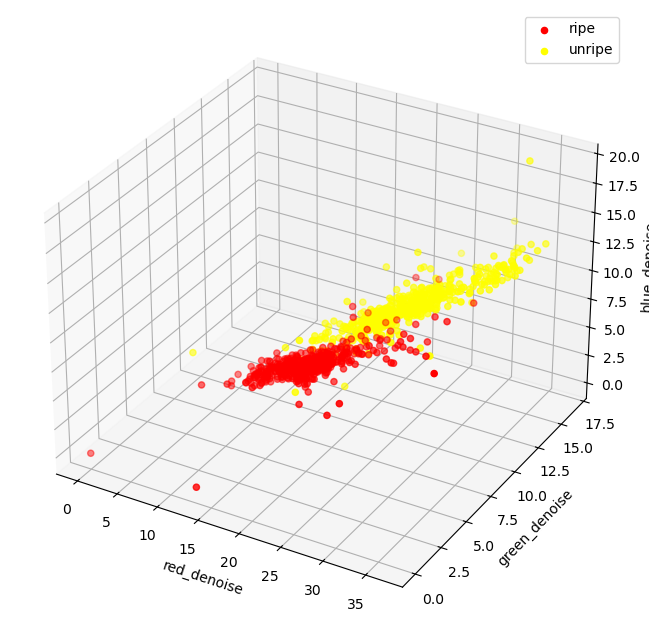

In [98]:

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
#idx = ['log_L_lab', 'dominance', 'log_a_lab'];
idx = ['red_denoise', 'green_denoise', 'blue_denoise'];
#idx = ['val2_sin_hue', 'val2_cos_hue', 'saturation'];
#idx = ['ratio_rg', 'ratio_gb', 'ratio_br'];
#idx = ['L_lab', 'a_lab', 'b_lab']
colors = {'ripe': 'red', 'unripe': 'yellow'}
for label in colors:
    subset = colors_df[colors_df['label'] == label]
    ax.scatter(subset[idx[0]], subset[idx[1]], subset[idx[2]], c=colors[label], label=label,s=20)

ax.set_xlabel(idx[0])
ax.set_ylabel(idx[1])
ax.set_zlabel(idx[2])
ax.legend()
plt.show()


In [116]:

np.where(np.isinf(X))
#(array([133, 133]), array([12, 13]))


(array([133, 133]), array([12, 13]))

In [122]:
#X = colors_df.drop(columns=['label'])
X = colors_df[['red_denoise', 'green_denoise', 'blue_denoise']]
y = (colors_df['label'] == 'ripe').astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
feature_list = X.columns.tolist()


false_negative_penalty = -15 # penalty - missed points
false_positive_penalty = -35 # - missed points

model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    scale_pos_weight=(false_positive_penalty / false_negative_penalty),
    objective='binary:logistic',
)

model.fit(X_train, y_train)

pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))


Accuracy: 0.9656862745098039
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       102
           1       0.97      0.96      0.97       102

    accuracy                           0.97       204
   macro avg       0.97      0.97      0.97       204
weighted avg       0.97      0.97      0.97       204



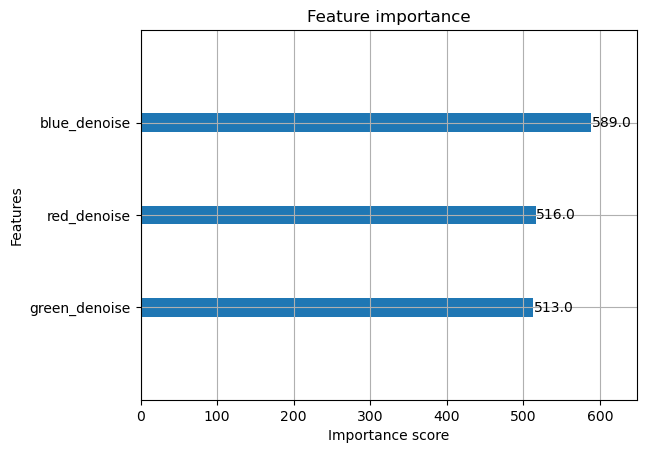

In [123]:
xgb.plot_importance(model, max_num_features=20)
plt.show()

single rule approximation, export tree as text

In [124]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, model.predict_proba(X_train)[:,1] > 0.5)

from sklearn.tree import export_text
print(export_text(dt, feature_names=list(X.columns)))
# 
# 
pred = dt.predict(X_test)
print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))

|--- blue_denoise <= 7.65
|   |--- blue_denoise <= 7.35
|   |   |--- class: True
|   |--- blue_denoise >  7.35
|   |   |--- green_denoise <= 7.00
|   |   |   |--- class: False
|   |   |--- green_denoise >  7.00
|   |   |   |--- class: True
|--- blue_denoise >  7.65
|   |--- blue_denoise <= 8.65
|   |   |--- red_denoise <= 24.35
|   |   |   |--- class: False
|   |   |--- red_denoise >  24.35
|   |   |   |--- class: True
|   |--- blue_denoise >  8.65
|   |   |--- green_denoise <= 8.65
|   |   |   |--- class: False
|   |   |--- green_denoise >  8.65
|   |   |   |--- class: False

Accuracy: 0.9754901960784313
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       102
           1       0.99      0.96      0.98       102

    accuracy                           0.98       204
   macro avg       0.98      0.98      0.98       204
weighted avg       0.98      0.98      0.98       204



In [120]:
print(port(dt))


NameError: name 'port' is not defined